# ACCESS Sea Ice Thickness

In [1]:
import glob
import dask.distributed as dsk
from pathlib import Path
import numpy as np
import xarray as xr

import cf_xarray

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import pyproj
import cartopy.feature as cft
import glob

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37407/status,
Dashboard: /proxy/37407/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37263,Workers: 28
Dashboard: /proxy/37407/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:36981,Total threads: 1
Dashboard: /proxy/32841/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:41215,


In [3]:
#Importing data

pathsC = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ice/OUTPUT/iceh*.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/outpu*/ice/OUTPUT/iceh*.nc'))

In [4]:
VARS = ['hi_m']
time_slice = slice('1910-01-01','1919-12-31')

In [5]:
# Time variant variables
def preprocess(ds):
    ds = ds[['hi_m']]
    
    return ds


In [6]:
cont = xr.open_mfdataset(
        pathsC,
        preprocess = preprocess,
        combine="by_coords",
        chunks={"time": 1},
        decode_coords=False,
        compat="override",
        data_vars="minimal",
        coords="minimal",
    )

In [7]:
melt = xr.open_mfdataset(
        pathsM,
        preprocess = preprocess,
        combine="by_coords",
        chunks={"time": 1},
        decode_coords=False,
        compat="override",
        data_vars="minimal",
        coords="minimal",
    )

In [8]:
cont = cont.sel(time=slice('1910-01-01','1919-12-31'))
melt = melt.sel(time=slice('1910-01-01','1919-12-31'))

In [9]:
cont

<xarray.Dataset> Size: 5GB
Dimensions:  (time: 120, nj: 2700, ni: 3600)
Coordinates:
  * time     (time) object 960B 1910-01-01 00:00:00 ... 1919-12-01 00:00:00
Dimensions without coordinates: nj, ni
Data variables:
    hi_m     (time, nj, ni) float32 5GB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       Los Alamos Sea Ice Model (CICE) Version 5
    comment:      This Year Has 365 days
    comment2:     File written on model date 19000201
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      This dataset was created on 2023-04-17 at 23:18:20.3
    io_flavor:    io_netcdf

In [10]:
# data in coordinates (TLON TLAT time)
cont = cont.rename({'ni': 'xt_ocean', 'nj': 'yt_ocean'})
melt = melt.rename({'ni': 'xt_ocean', 'nj': 'yt_ocean'})

In [11]:
grid = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')

In [12]:
# Assuming 'grid' has geolon and geolat with matching dimensions to data_2
cont = cont.assign_coords(
    xt_ocean=("xt_ocean", grid.xt_ocean.values),  # along x dimension
    yt_ocean=("yt_ocean", grid.yt_ocean.values)   # along y dimension
)

melt = melt.assign_coords(
    xt_ocean=("xt_ocean", grid.xt_ocean.values),  # along x dimension
    yt_ocean=("yt_ocean", grid.yt_ocean.values)   # along y dimension
)

In [13]:
cont

<xarray.Dataset> Size: 5GB
Dimensions:   (time: 120, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time      (time) object 960B 1910-01-01 00:00:00 ... 1919-12-01 00:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    hi_m      (time, yt_ocean, xt_ocean) float32 5GB dask.array<chunksize=(1, 675, 900), meta=np.ndarray>
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       Los Alamos Sea Ice Model (CICE) Version 5
    comment:      This Year Has 365 days
    comment2:     File written on model date 19000201
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      This dataset was created on 2023-04-17 at 23:18:20.3
    io_flavor:    io_netcdf

In [14]:
# Import area
area_old = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t']
var = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean.nc')['salt']
area_corr = area_old*(var.isel(time=0,st_ocean=0)*0 +1)

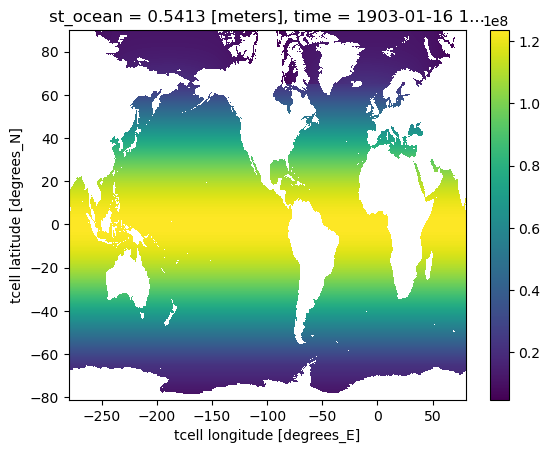

In [15]:
area_corr.plot()

In [16]:
# Define sea ice thickness
siv_C = (cont['hi_m'] * area_corr).sel(yt_ocean=slice(None,-39))
siv_M = (melt['hi_m'] * area_corr).sel(yt_ocean=slice(None,-39))

# Map

In [23]:
siv_map_C = siv_C.sel(time=slice('1915-01-01','1919-12-31')).mean(dim='time')
siv_map_M = siv_M.sel(time=slice('1915-01-01','1919-12-31')).mean(dim='time')

In [24]:
siv_map_anom = siv_map_M - siv_map_C
siv_map_anom

<xarray.DataArray (yt_ocean: 821, xt_ocean: 3600)> Size: 12MB
dask.array<sub, shape=(821, 3600), dtype=float32, chunksize=(675, 900), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 7kB -81.11 -81.07 -81.02 ... -39.1 -39.03
    geolon_t  (yt_ocean, xt_ocean) float32 12MB nan nan nan ... 79.85 79.95
    geolat_t  (yt_ocean, xt_ocean) float32 12MB nan nan nan ... -39.03 -39.03
    st_ocean  float64 8B 0.5413

In [27]:
siv_map_C = siv_map_C.load()

KeyboardInterrupt: 

In [ ]:
siv_map_M = siv_map_M.load()

In [25]:
siv_map_anom = siv_map_anom.load()

KeyboardInterrupt: 

In [ ]:
siv_map_anom

In [ ]:
sit_map_anom.plot()

In [17]:
## Creating shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [18]:
depth = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom5')

In [ ]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

siv_map_anom.plot(
    x="xt_ocean",
    y="yt_ocean",
    transform=ccrs.PlateCarree(),
    vmin=-2000000,
    vmax=2000000,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea Ice Volume Anomaly (m$^{3}$)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("ACCESS-OM2-01 Sea Ice Volume anomaly");

In [ ]:
siv_map_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_map_cont_prescribed_ACCESS.nc')
siv_map_M.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_map_melt_prescribed_ACCESS.nc')
siv_map_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_map_anom_prescribed_ACCESS.nc')

# Time series

In [19]:
cont_shelf = siv_C.where(shelf_mask == 1)
melt_shelf = siv_M.where(shelf_mask == 1)

In [20]:
cont_shelf = cont_shelf.drop_vars(['geolon_t','geolat_t'])
melt_shelf = melt_shelf.drop_vars(['geolon_t','geolat_t'])

In [21]:
cont_shelf

<xarray.DataArray (time: 120, yt_ocean: 510, xt_ocean: 3600)> Size: 881MB
dask.array<where, shape=(120, 510, 3600), dtype=float32, chunksize=(1, 510, 900), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 960B 1910-01-01 00:00:00 ... 1919-12-01 00:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
    st_ocean  float64 8B 0.5413

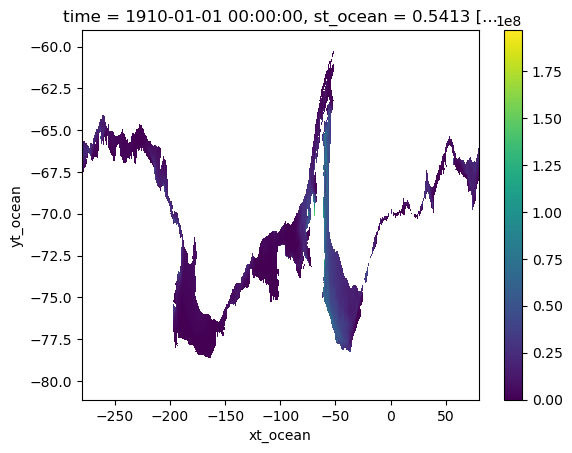

In [22]:
cont_shelf.isel(time=0).plot()

In [23]:
# Spatial average
siv_time_C = (area_corr * cont_shelf).sum(['xt_ocean', 'yt_ocean']) / area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean'])
siv_time_M = (area_corr * melt_shelf).sum(['xt_ocean', 'yt_ocean']) / area_corr.where(shelf_mask == 1).sum(['xt_ocean', 'yt_ocean'])

In [24]:
siv_time_C

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    st_ocean  float64 8B 0.5413
  * time      (time) object 960B 1910-01-01 00:00:00 ... 1919-12-01 00:00:00

In [25]:
siv_time_C = siv_time_C.load()

In [26]:
siv_time_M = siv_time_M.load()

In [30]:
siv_time_C['time'] = siv_time_C.indexes['time'].to_datetimeindex()

In [32]:
siv_time_M['time'] = siv_time_M.indexes['time'].to_datetimeindex()

Text(0.5, 1.0, 'Sea Ice Volume ACCESS-OM2-01 prescribed')

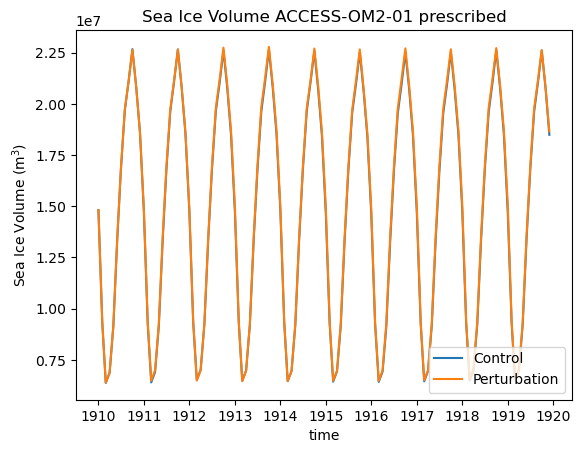

In [33]:
siv_time_C.plot(label = 'Control')
siv_time_M.plot(label = 'Perturbation')

plt.legend(loc='lower right')
plt.ylabel('Sea Ice Volume (m$^{3}$)');
plt.title('Sea Ice Volume ACCESS-OM2-01 prescribed')

In [34]:
# Regular anomaly
siv_time_anom = siv_time_M - siv_time_C
siv_time_anom = siv_time_anom.load()

Text(0.5, 1.0, 'ACCESS-OM2-01')

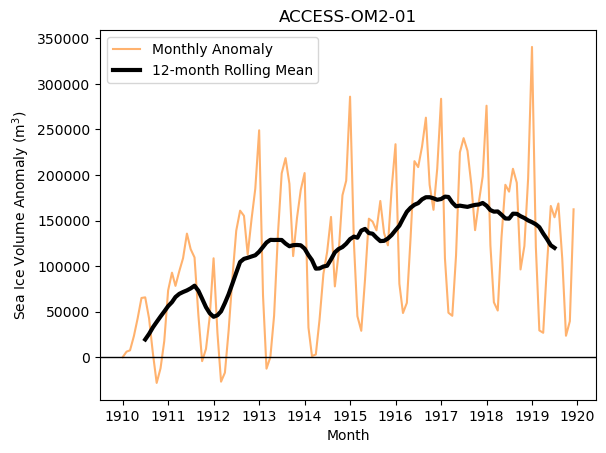

In [35]:
# Plot original anomaly
siv_time_anom.plot(label='Monthly Anomaly', alpha=0.6, color='tab:orange')

# Add rolling mean (12-month window)
siv_time_anom.rolling(time=12, center=True).mean().plot(
    label='12-month Rolling Mean', linewidth=3, color='black'
)

plt.ylabel('Sea Ice Volume Anomaly (m$^{3}$)')
plt.xlabel('Month')
plt.legend()
plt.axhline(0, color='k', linewidth=1, linestyle='-')
plt.title("ACCESS-OM2-01")
#plt.grid(True)

Text(0, 0.5, 'Sea Ice Volume (m$^{3}$)')

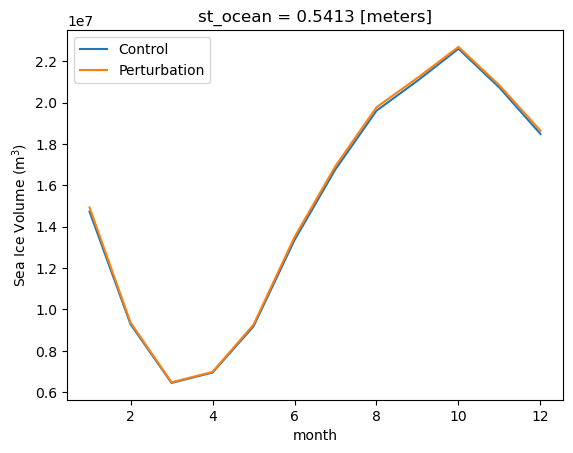

In [36]:
siv_time_C.groupby('time.month').mean('time').plot(label='Control')
siv_time_M.groupby('time.month').mean('time').plot(label='Perturbation')

plt.legend()
plt.ylabel('Sea Ice Volume (m$^{3}$)')

Text(0.5, 0, 'Month')

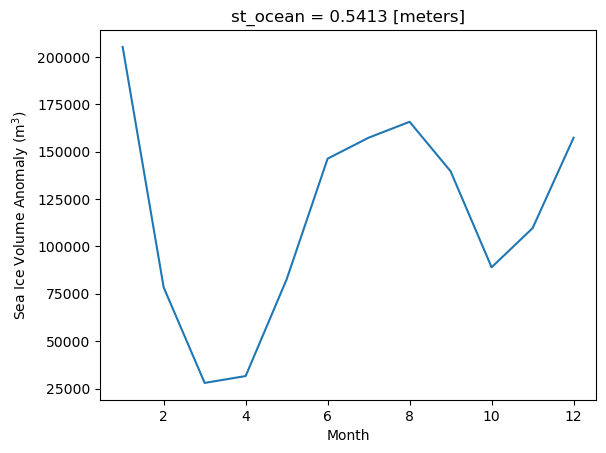

In [37]:
seasonal_anom = (siv_time_M.groupby('time.month').mean('time') - siv_time_C.groupby('time.month').mean('time'))
seasonal_anom.plot()

plt.ylabel('Sea Ice Volume Anomaly (m$^{3}$)')
plt.xlabel('Month')

In [38]:
# Save data
siv_time_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_time_C_prescribed_ACCESS.nc')
siv_time_M.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_time_M_prescribed_ACCESS.nc')
siv_time_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_time_anom_prescribed_ACCESS.nc')
seasonal_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_seasonal_time_anom_prescribed_ACCESS.nc')

# Comparison

In [54]:
# Compare to Panant
siv_acc_anom = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_time_anom_prescribed_ACCESS.nc')
siv_pan_anom = xr.open_dataarray('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_time_anom_prescribed_Pan01.nc')

In [55]:
# Colours
from matplotlib.colors import to_rgba

colors = {'pan01_res': '#0000a2',
          'pan005_res': '#E84141',
          'pan01_pre' : '#18669C',
          'access_pre': 'tab:orange'}

def lighten(color, amount=0.4):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

In [56]:
siv_acc_anom = siv_acc_anom.to_series()
siv_pan_anom = siv_pan_anom.to_series()

siv_pan_anom_new = siv_pan_anom['2001-01-01':'2010-12-16']
siv_acc_anom_new = siv_acc_anom['1910-01-01':'1919-12-16']

siv_pan_anom_new.index = range(1, len(siv_pan_anom_new)+1)
siv_acc_anom_new.index = range(1, len(siv_acc_anom_new)+1)

Text(0.5, 1.0, 'Sea Ice Volume anomalies')

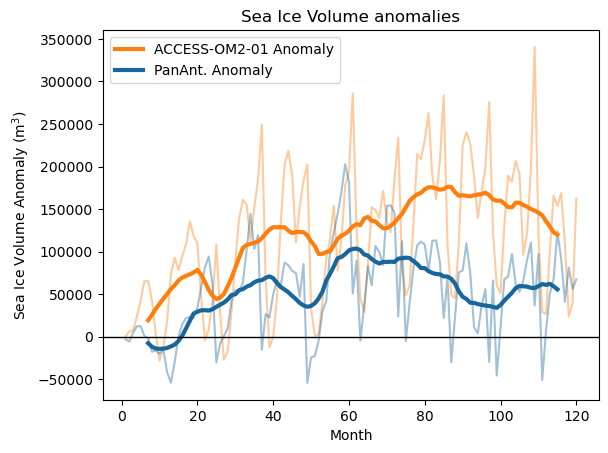

In [60]:
# Plot original anomaly
plt.plot(siv_acc_anom_new.index, siv_acc_anom_new.values, alpha=0.4, color=colors['access_pre'])
plt.plot(siv_pan_anom_new.index, siv_pan_anom_new.values,alpha=0.4, color=colors['pan01_pre'])

# Add rolling mean (12-month window)
siv_acc_anom_rm = siv_acc_anom_new.rolling(window=12, center=True).mean()
siv_pan_anom_rm = siv_pan_anom_new.rolling(window=12, center=True).mean()
    
plt.plot(siv_acc_anom_rm.index, siv_acc_anom_rm.values,
    label='ACCESS-OM2-01 Anomaly', linewidth=3, color=colors['access_pre']
)
plt.plot(siv_pan_anom_rm.index, siv_pan_anom_rm.values,
    label='PanAnt. Anomaly', linewidth=3, color=colors['pan01_pre']
)

plt.ylabel('Sea Ice Volume Anomaly (m$^{3}$)')
plt.xlabel('Month')
plt.legend()
plt.axhline(0, color='k', linewidth=1, linestyle='-')
plt.title("Sea Ice Volume anomalies")
#plt.grid(True)